# Asset Allocation Asssignment

### Installing and Importing libraries

In [4]:
#Installation of all necessary libraries
!pip install xlrd
!pip install scikit-learn
#!pip install pandas-profiling
!pip install boruta
#!pip install scikit-garden
 
#Import of the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import sklearn

### Main Funciton

### EDA

In [5]:
#plotting the index, moviang average, diffrenec and percent_change
def data_plot(df_index):
    fig,(ax1,ax2,ax3) =plt.subplots(1,3,figsize=(16,6))
    df_index.plot(kind='line', color='red',ax=ax1)
    df_index.diff(axis = 0, periods = 1).add_suffix('_change').plot(kind='line', color='blue',ax=ax2)
    df_index.pct_change().add_suffix('_%change').plot(kind='line', color='green',ax=ax3)
    df_index.rolling(window=6).mean().add_suffix('_6M_ma').plot(kind='line', color='blue',ax=ax1)
    plt.show()
    # Monthly log returns
    #monthly_log_returns = np.log(df_index.pct_change()+1)

In [6]:
#Correlation heatmap
def correlation(df_features,df_index):
    df=pd.concat([df_features,df_index], axis=1)
    corrMatrix = df.corr()
    #print(corrMatrix)
    plt.figure(figsize=(16, 16))
    heatmap=sn.heatmap(corrMatrix, vmin=-1, vmax=1,  annot=False, cmap='RdBu')
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
    plt.show()
    #display highly correlated features
    def correl(X_train,thres):
        cor = X_train.corr()
        corrm = np.corrcoef(X_train.transpose())
        corr = corrm - np.diagflat(corrm.diagonal())
        print("max corr:",corr.max(), ", min corr: ", corr.min())
        c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
        high_cor = c1[c1.values!=1]   
        display(high_cor[high_cor>thres])
        return high_cor[high_cor>thres]
    high_cor = correl(df,0.96)
    return high_cor

In [7]:
#Feature Selection
def Boruta_Feature_Selection (X,y):
    from boruta import BorutaPy
    from sklearn.ensemble import RandomForestRegressor
    import numpy as np
    ###initialize Boruta
    forest = RandomForestRegressor(
       n_jobs = -1, 
       max_depth = 5
    )
    boruta = BorutaPy(
       estimator = forest, 
       n_estimators = 'auto',
       max_iter = 100 # number of trials to perform
    )
    ### fit Boruta (it accepts np.array, not pd.DataFrame)
    boruta.fit(np.array(X), np.array(y))
    ### print results
    green_area = X.columns[boruta.support_].to_list()
    blue_area = X.columns[boruta.support_weak_].to_list()
    return green_area
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)

In [8]:
#Feature Selection
def RFE_Feature_Selection(X,y):
    from sklearn.feature_selection import RFE
    from sklearn.ensemble import RandomForestRegressor
    # #Selecting the Best important features according to Logistic Regression
    rfe_selector = RFE(estimator=RandomForestRegressor(),n_features_to_select = 12, step = 1)
    rfe_selector.fit(X, y)
    return X.columns[rfe_selector.get_support()]

In [9]:
def Important_features(df_features,df_index):
    df_important_features=pd.DataFrame()
    green_area_RFE=RFE_Feature_Selection(df_features.loc[df_features.index <= '2003-01-31'],df_index.loc[df_index.index <= '2003-01-31'].values.ravel())
    listrfe=sorted(green_area_RFE.tolist())
    df_important_features['period 2000 - 2003'] = listrfe
    green_area_RFE=RFE_Feature_Selection(df_features.loc[(df_features.index > '2003-01-31') & (df_features.index < '2009-01-31')],df_index.loc[(df_index.index > '2003-01-31') & (df_index.index < '2009-01-31')].values.ravel())
    listrfe=sorted(green_area_RFE.tolist())
    df_important_features['period 2003-2009'] = listrfe
    green_area_RFE=RFE_Feature_Selection(df_features.loc[df_features.index >= '2009-01-31'],df_index.loc[df_index.index >= '2009-01-31'].values.ravel())
    listrfe=sorted(green_area_RFE.tolist())
    df_important_features['period 2009-2020'] = listrfe
    return df_important_features    

### RF Predictive model

In [10]:
#Train_test_split. For the task only one-month ahead will be predicted and the rest in training period size
#is used as a training set.
def data_split_time_series(X, y, start_month, train_size_months): 
    split = start_month+train_size_months
    return  X[start_month:split], X[split:split+1], y[start_month:split], y[split:split+1]

In [11]:
def Random_Forest (X,y,start_month,train_size_months):
    X_train, X_test, y_train, y_test=data_split_time_series(X,y,start_month,train_size_months)
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(max_depth=6, random_state=42)
    rf.fit(X_train, y_train)
    #We’re now going to apply the constructed model to make predictions on the training set and test set as follows:
    y_rf_train_pred = rf.predict(X_train)
    y_rf_test_pred = rf.predict(X_test)
    y_rf_test_pred=pd.DataFrame(y_rf_test_pred,columns=['Prediction'])
    y_rf_test_pred.index=y_test.index
#    y_rf_test_pred['mape'] =100* abs(y_rf_test_pred['Prediction'] - y_test[:,-1]).div(y_test[:,-1].values).abs()
    rfresult=pd.concat([y_rf_test_pred,y_test], axis=1)
    return rfresult

### Simple Asset Allocation Strategy

In [12]:
def benchmarking_strategy(df_index, short_window, long_window):
    # Initialize the short and long windows
    short_window = 3
    long_window = 24

    # Initialize the `signals` DataFrame with the `signal` column
    signals = pd.DataFrame(index=df_index.index)
    signals['signal'] = 0.0

    # Create short simple moving average over the short window
    signals['short_mavg'] = df_index.rolling(window=short_window, min_periods=1, center=False).mean()

    # Create long simple moving average over the long window
    signals['long_mavg'] = df_index.rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    # Add a subplot and label for y-axis
    fig = plt.figure()
    ax1 = fig.add_subplot(111,  ylabel='Index')
    
    # Plot the index price
    df_index.plot(ax=ax1, color='r', lw=2.)
    
    # Plot the short and long moving averages
    signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the buy signals
    ax1.plot(signals.loc[signals.positions == 1.0].index, signals.short_mavg[signals.positions == 1.0],'^', markersize=10, color='m')
             
    # Plot the sell signals
    ax1.plot(signals.loc[signals.positions == -1.0].index, signals.short_mavg[signals.positions == -1.0],'v', markersize=10, color='k')
    # Show the plot
    fig = plt.figure()
    signals.signal.plot()
    plt.show()
    return signals

In [13]:
def strategy(prediction,df_index,short_window,long_window):
    # Initialize the short and long windows
    #short_window = 3
    #long_window = 24

    df3 = pd.concat([prediction,df_index], axis=1)
    print(df3)

    #for i in range(start_month,train_size_month)
    #print(pd.concat([df_index.iloc[0:6,:],df_features.iloc[3:6,0:2]], axis=1,join='inner'))
    #def MA_month_ahead(pred,df_index,window):
    df3['roll_short'] = df3['MSCI All Country World Index'].rolling(short_window-1).sum().shift(+1)
    df3['roll_long'] = df3['MSCI All Country World Index'].rolling(long_window-1).sum().shift(+1)
    #df3['ma']=df3[]
    df3['short_mavg'] = (df3['Prediction'] + df3['roll_short'])/short_window
    df3['long_mavg'] = (df3['Prediction'] + df3['roll_long'])/long_window
    print(df3)
    #df3=df3.dropna()
    print(df3)
    
    
    
    
    # Initialize the `signals` DataFrame with the `signal` column
    signals = pd.DataFrame(index=df3.index)
    signals['signal'] = 0.0

    # Create short simple moving average over the short window
    #signals['short_mavg'] = df_index.rolling(window=short_window, min_periods=1, center=False).mean()
    signals['short_mavg'] = df3['short_mavg']

    # Create long simple moving average over the long window
    signals['long_mavg'] =  df3['long_mavg']
    #df_index.rolling(window=long_window, min_periods=1, center=False).mean()

    # Create signals
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   

    # Generate trading orders
    signals['positions'] = signals['signal'].diff()
    fig = plt.figure()
    # Add a subplot and label for y-axis
    ax1 = fig.add_subplot(111,  ylabel='Index')
    
    # Plot the closing price
    df_index.plot(ax=ax1, color='r', lw=2.)
    
    # Plot the short and long moving averages
    signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the buy signals
    #ax1.plot(signals.loc[signals.positions == 1.0].index, signals.short_mavg[signals.positions == 1.0],'^', markersize=10, color='m')
             
    # Plot the sell signals
    #ax1.plot(signals.loc[signals.positions == -1.0].index, signals.short_mavg[signals.positions == -1.0],'v', markersize=10, color='k')
    # Show the plot
    fig = plt.figure()
    signals.signal.plot()
    plt.show()
    return signals
    # Print `signals`
    print(signals)
    print(signals)

#signals = strategy(pred)

### Strategy backtesting

In [14]:
def backtesting (signals,df_index, initial_capital= float(100000.0)):
    # Set the initial capital
    #initial_capital= float(100000.0)

    # Create a DataFrame `positions`
    positions = pd.DataFrame(index=signals.index).fillna(0.0)

    # Buy a 100 shares
    positions['Index'] = 100*signals['signal']
  
    # Initialize the portfolio with value owned   
    portfolio = positions.multiply(df_index['MSCI All Country World Index'], axis=0)
    # Store the difference in shares owned 
    pos_diff = positions.diff()
    
    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(df_index['MSCI All Country World Index'], axis=0)).sum(axis=1)

    # Add `cash` to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(df_index['MSCI All Country World Index'], axis=0)).sum(axis=1).cumsum()   

    # Add `total` to portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']

    # Add `returns` to portfolio
    portfolio['returns'] = portfolio['total'].pct_change()
    
    
    # Import the `pyplot` module as `plt`
    import matplotlib.pyplot as plt
    
    # Create a figure
    fig = plt.figure(figsize=(16,3))

    ax1 = fig.add_subplot(111, ylabel='Portfolio value')


    
    
    # Plot the equity curve in dollars
    portfolio['total'].plot(ax=ax1, lw=2.)

    ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='m')
    ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='k')

    # Show the plot

    # Plot the results
    # Show the plot
    plt.title('Portfolio Value')
    plt.show()
    fig = ax1.get_figure()
    fig.savefig('Portfolio_Value.png')
    
    return portfolio.iloc[:-1,:]
    # Print the first lines of `portfolio`
    print(portfolio.tail())

### Evaluating Moving Average Crossover Strategy

In [15]:
def portfolio_metrics(portfolio, index):
    
    #12 months are within a year
    window = 12 
    # Isolate the returns of your strategy
    returns = portfolio['returns']
    largest_monthly_gain=returns.max()
    largest_monthly_loss=returns.min()
    
    # annualized Sharpe ratio
    sharpe_ratio = np.sqrt(window) * (returns.mean() / returns.std())
    # 3Y Rolling Annualised Sharpe
    rolling = returns.rolling(window=36)
    rolling_sharpe_s = np.sqrt(36) * (rolling.mean() / rolling.std())
    # Print the Sharpe ratio
    #print('Annualaized Sharpe Rario:',sharpe_ratio)

    # Calculate the max drawdown in the past window months for each month 
    rolling_max = index['MSCI All Country World Index'].rolling(window, min_periods=1).max()
    monthly_drawdown = index['MSCI All Country World Index']/rolling_max - 1.0

    # Calculate the minimum (negative) monthly drawdown
    max_monthly_drawdown = monthly_drawdown.rolling(window, min_periods=1).min()

    # Plot the results
    ax=monthly_drawdown.plot(figsize=(16,3),linewidth=3)
    ax=max_monthly_drawdown.plot(figsize=(16,3),linewidth=3)
    # Show the plot
    plt.title('Drawdown')
    plt.show()
    fig = ax.get_figure()
    fig.savefig('Drawdown.png')
    
    ax1 = rolling_sharpe_s.plot(figsize=(16,3),linewidth=3) 
    plt.title('3 years Rolling Sharpe Ratio')
    plt.show()
    fig = ax1.get_figure()
    fig.savefig('3_years_Rolling_SR.png')
    # Get the number of days in `aapl`
    #months = (index.index[-1] - index.index[0]).months
    
    # Plot the results
    ax2=returns.plot(figsize=(16,3),linewidth=3)
#    ax=max_monthly_drawdown.plot(figsize=(16,3))
    # Show the plot
    plt.title('Returns')
    plt.show()
    fig = ax2.get_figure()
    fig.savefig('Returns.png')

    # Calculate the CAGR 
    #cagr = ((((index['MSCI All Country World Index'][-1]) / index['MSCI All Country World Index'][1])) ** (12/months)) - 1

    # Print the CAGR
    #print(cagr)

    return sharpe_ratio, max_monthly_drawdown.min(), largest_monthly_gain, largest_monthly_loss

### HTML Reporting

In [16]:
def Reporting(performance, high_cor, df_index, df_important_features):
    # Set up multiple variables to store the titles, text within the report
    page_title_text='Asset Allocation Assignment Report (Daria Mustafina)'
    # Combine them together using a long f-string
    html = f'''
        <html>
            <head>
                <title>{page_title_text}</title>
            </head>
            <body>
                <h1>{page_title_text}</h1>
                <h2>{'Portoflio Performance Metrics'}</h2>
                <p>{'Drawdown'}</p>
                <img src='Drawdown.png' width="900">
                <p>{'3 years Rolling Sharpe Ratio'}</p>
                <img src='3_years_Rolling_SR.png' width="900">
                <p>{'Portfolio Value'}</p>
                <img src='Portfolio_value.png' width="900">
                <h2>{'Portoflio Performance Metrics'}</h2>
                <img src='performance.png' width="900">
                <h2>{'Important Features for different periods'}</h2>
                <img src='important_features.png' width="900">
            </body>
        </html>
        '''
    # Write the html string as an HTML file
    with open('html_assignment_report.html', 'w') as f:
        f.write(html)

In [17]:
#Tables
def render_mpl_table(data, col_width=12.0, row_height=1, font_size=24,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [32]:
def S_Main():
    Filename = 'Data_MultiAsset.xlsx'
    
    #Read the features and index from Excel file
    df_features = pd.read_excel(Filename, sheet_name=0).set_index('Date')
    df_index = pd.read_excel(Filename, sheet_name=1).set_index('Date')
    df=pd.concat([df_features,df_index], axis=1)

    #Explarotory Data Analysis
    #plotting the index, moviang average, diffrenec and percent_change
    data_plot(df_index)
    
    #Check for null values and data type
    df.info()
    if (df.isnull().any().any() != False): 
        print('there are missing values')
    else: 
        print('No missing values in the dataset are observed')
        
    #Look at data distribution for features and index
    df.describe()
    
    #Plot the pairplots for all the features and index
    for col in df_features.columns:
        ax = df_features.plot(kind='line', y=col)
        df_index.plot(kind='line', y='MSCI All Country World Index',color='red', ax=ax, secondary_y=True)
    ##plt.show()
    print('Some features are relevant only for particular period of time (like Fed Balance Sheet before and after 2008)')
  
    #Correlations for features and the difference of features with each other and index
    high_cor=correlation(df_features,df_index)
    correlation(df_features.diff(axis = 0, periods = 1).add_suffix('_pct'),df_index)

    # Remove highly-correlated features from features 
    # From domain knowledge and correlation coefficients we could exclude US Real Personal Income exTrans 
    # and Eurozone Industrial Production exconstr and FED Excess Reserves from the features as they 
    # highly correlated with the other once US Real Personal Income, Eurozone Industrial Production manuf 
    # and Fed Balance Sheet, Sentiment environmental composite GLOBAL News Socia
    print("Highly Correlated Features\n",high_cor)
    df_features_selected = df_features.drop(['US Real Personal Income exTrans', 'Adv Retail Sales US exFood Services','FED Excess Reserves'], axis=1)
    
    # Important features 
    df_abs_corr = df.corr()[['MSCI All Country World Index']].abs()
    print(df_abs_corr.sort_values(by=['MSCI All Country World Index'],ascending=False))
    # Let us consider three periods 2001 - 2003, 2003 - 2009, 2009 - 2020
    df_important_features = Important_features(df_features_selected,df_index)
    print('Important features from RFE method for different periods\n',df_important_features)
    #Feature selection from chosen method
#    df_features=df_features_selected[Boruta_Feature_Selection(df_features_selected,df_index.values.ravel())]
    df_features=df_features_selected[RFE_Feature_Selection(df_features_selected,df_index.values.ravel())]
    
    #Predicting next month index value
    results = pd.DataFrame()
    #The size of the training data set
    train_size_months = 12
    for i in range(0,(len(df_features)-train_size_months-1)):
        results=results.append(Random_Forest(df_features,df_index,i,train_size_months))   
    ax = results.plot()
    results['mape'] =  100*abs(results['Prediction'].abs() - results.iloc[:,-1]).div(results.iloc[:,-1].values).abs()
    MAPE_model = results['mape'].mean()
    results.plot(kind='line', y='mape',color='red', ax=ax, secondary_y=True)
    print("Mean average percentage error of the model\n",MAPE_model,'%')
    plt.show()
    fig = ax.get_figure()
    fig.savefig('RF Index Prediction.png')
    pred = results['Prediction']
    print(results)
    print(type(results))
    
    #Simple Allocation Strategy MA Crossover
    short_window = 3
    long_window = 24
 #   signals = strategy(pred,short_window,long_window)
    signals_becnhmarking=benchmarking_strategy(df_index,short_window,long_window)
    signals = strategy(pred,df_index,short_window,long_window)
    
    #Allocation Strategy backtesting
    portfolio=backtesting(signals_becnhmarking,df_index)
    print(portfolio)
    total_return = (portfolio['total'].iloc[-1] - portfolio['total'].iloc[0])/portfolio['total'].iloc[0]
    sharpe_ratio, max_monthly_drawdown, largest_monthly_gain, largest_monthly_loss=portfolio_metrics(portfolio,df_index)
    performance = pd.DataFrame([sharpe_ratio,100*max_monthly_drawdown,100*largest_monthly_gain,100*largest_monthly_loss,100*total_return],columns=['Values'], index=['Annualized sharpe_ratio', 'Maximum Drawdown, %', 'Largest Monthly Gain, %', 'Largest Monthly Loss, %','Total Return, %'])
    performance=performance.round(2)
    fig,ax = render_mpl_table(performance.rename_axis('Performance Metrics Benchmarking').reset_index(), header_columns=0, col_width=12.0)
    fig.savefig('performance_benchmarking.png')
    print(performance)
    
    
    #Allocation Strategy backtesting
    portfolio=backtesting(signals,df_index)
    #Allocation Strategy Performance Evaluation
    total_return = (portfolio['total'].iloc[-1] - portfolio['total'].iloc[0])/portfolio['total'].iloc[0]
    sharpe_ratio, max_monthly_drawdown, largest_monthly_gain, largest_monthly_loss=portfolio_metrics(portfolio,df_index)
    performance = pd.DataFrame([sharpe_ratio,100*max_monthly_drawdown,100*largest_monthly_gain,100*largest_monthly_loss,100*total_return],columns=['Values'], index=['Annualized sharpe_ratio', 'Maximum Drawdown, %', 'Largest Monthly Gain, %', 'Largest Monthly Loss, %','Total Return, %'])
    performance=performance.round(2)
    fig,ax = render_mpl_table(df_important_features, header_columns=0, col_width=12.0)
    fig.savefig('important_features.png')
    fig,ax = render_mpl_table(performance.rename_axis('Performance Metrics').reset_index(), header_columns=0, col_width=12.0)
    fig.savefig('performance.png')

    
    #Reporting
    Reporting(performance, high_cor, df_index, df_important_features)

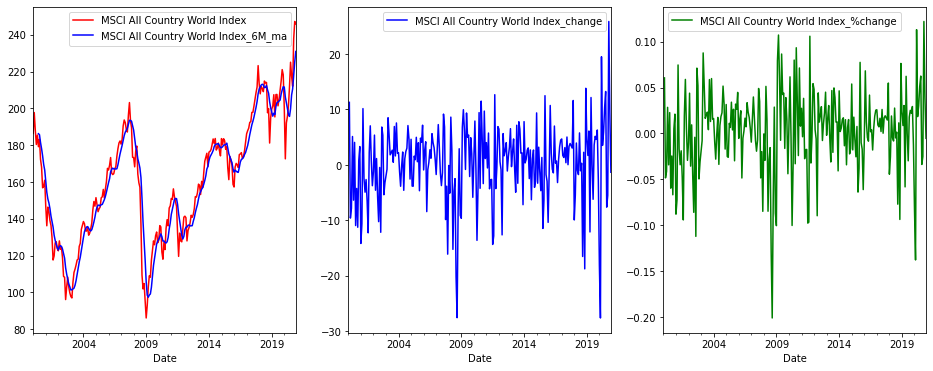

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2000-01-31 to 2020-12-31
Data columns (total 60 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Cycle Indicator Global                                252 non-null    float64
 1   Eurozone Retail Sales                                 252 non-null    float64
 2   Eurozone Industrial Production exconstr               252 non-null    float64
 3   Eurozone Industrial Production manuf                  252 non-null    float64
 4   US Privately Owned Housing Starts                     252 non-null    float64
 5   US HomeBuilders Market Index                          252 non-null    float64
 6   US Real Personal Income                               252 non-null    float64
 7   US Real Personal Income exTrans                       252 non-null    float64
 8   US Indus Prod Index                      

C:\Users\darya\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Some features are relevant only for particular period of time (like Fed Balance Sheet before and after 2008)


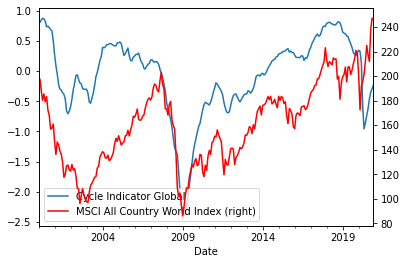

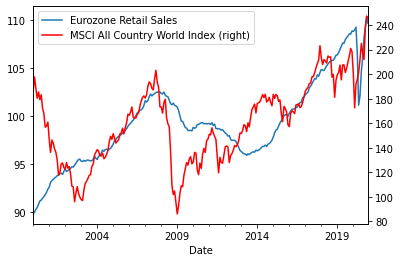

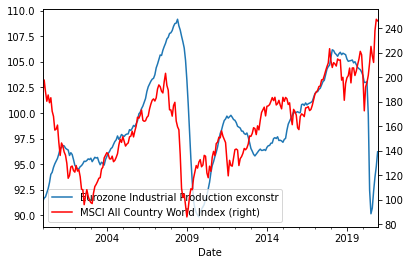

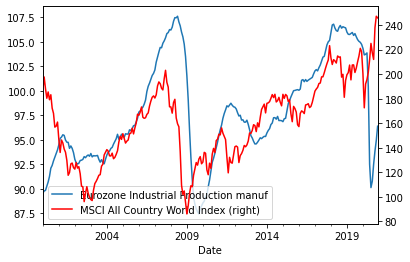

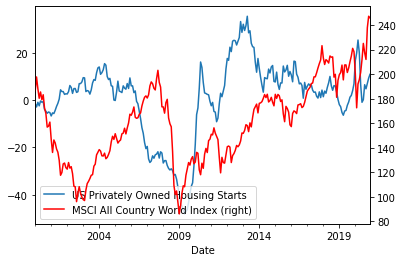

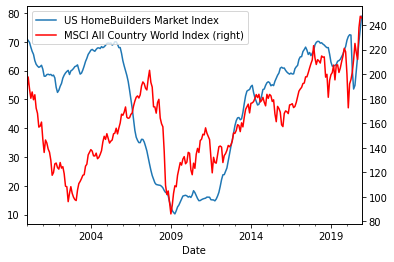

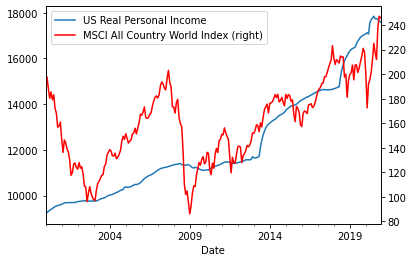

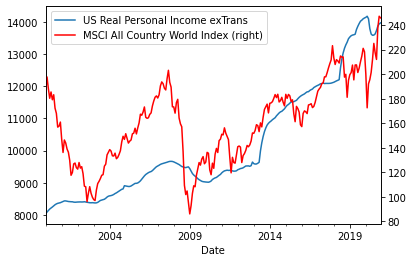

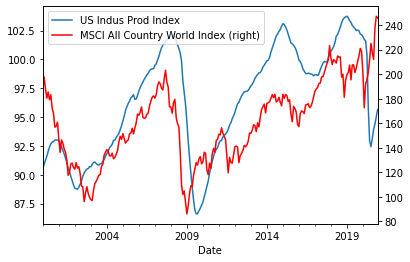

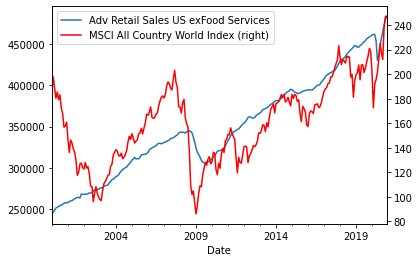

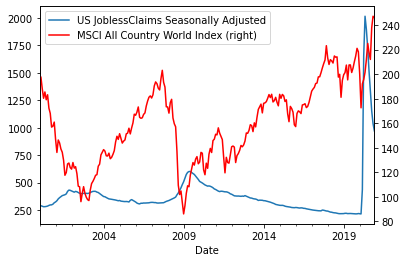

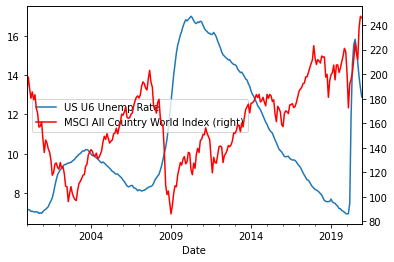

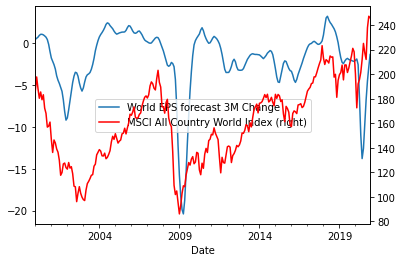

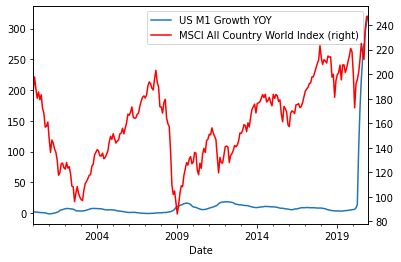

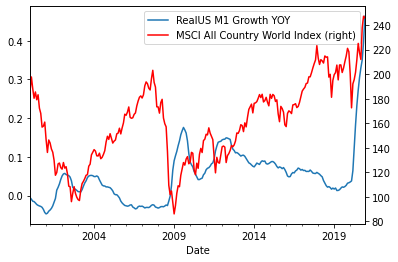

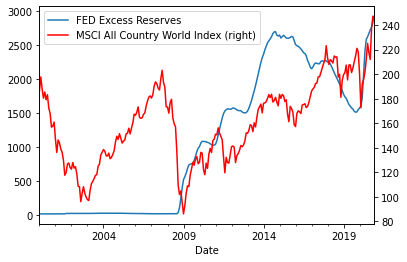

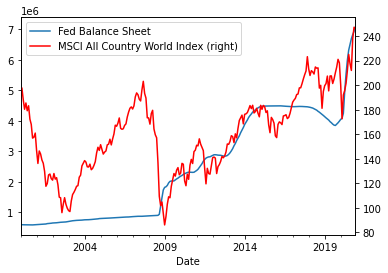

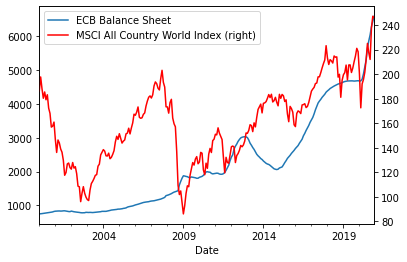

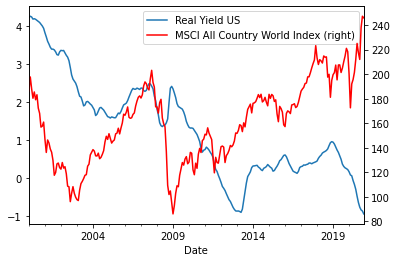

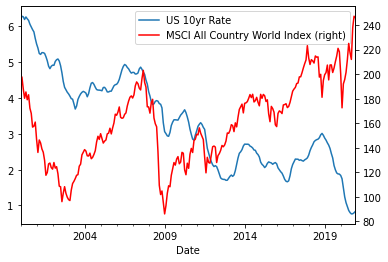

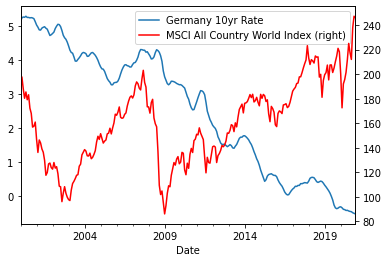

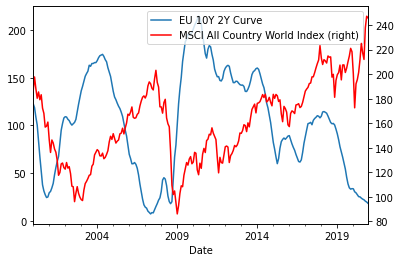

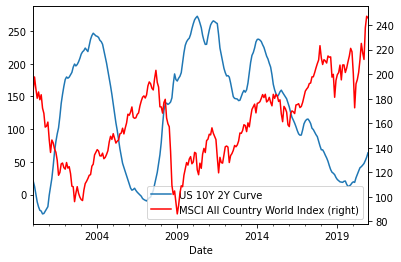

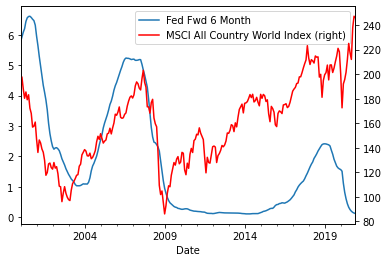

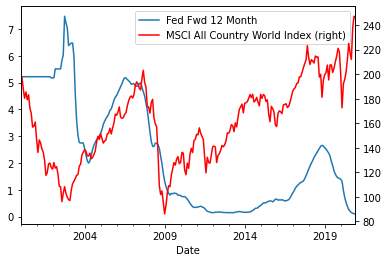

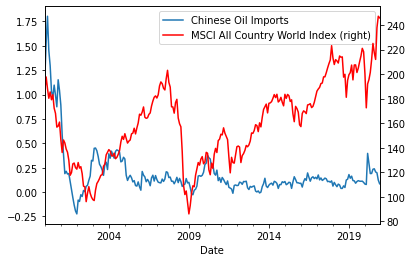

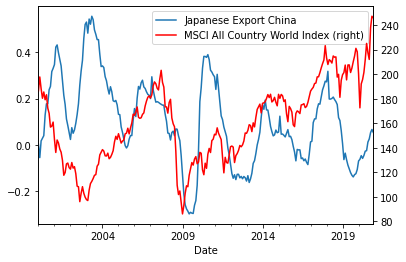

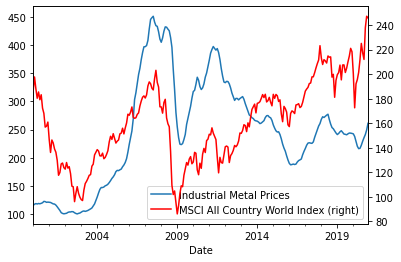

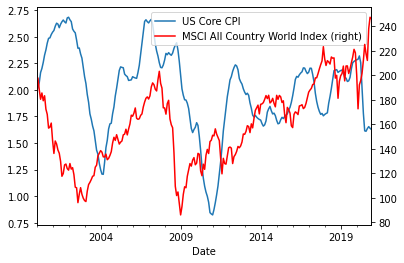

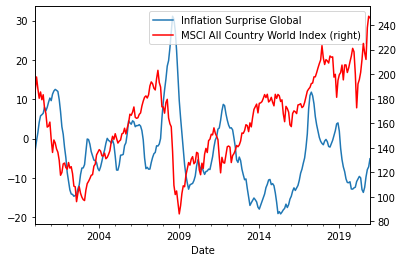

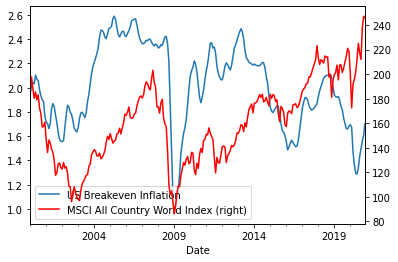

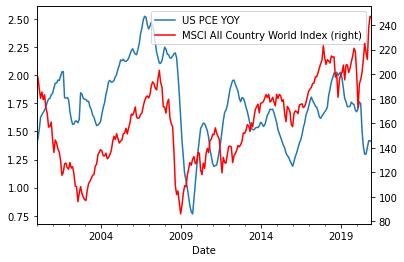

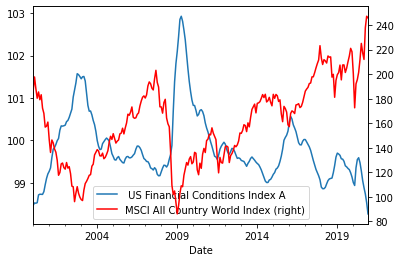

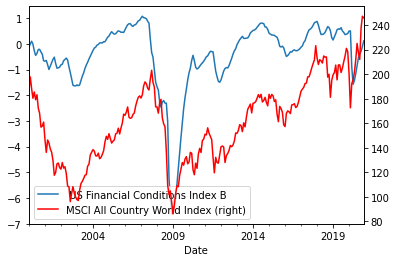

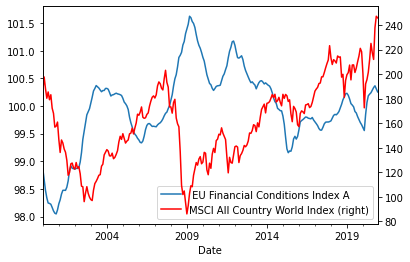

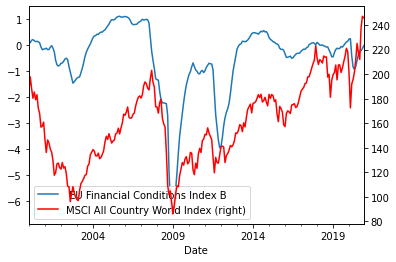

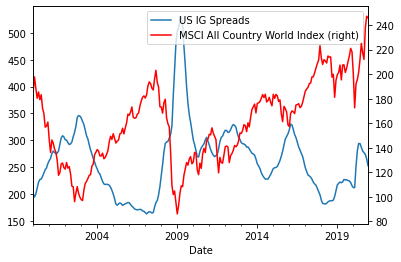

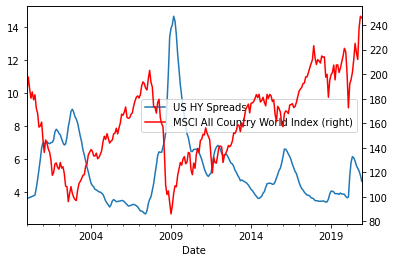

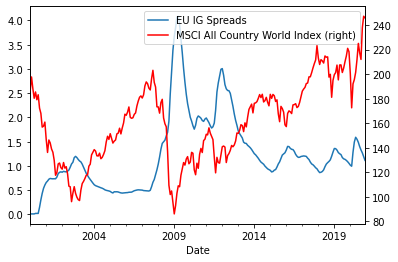

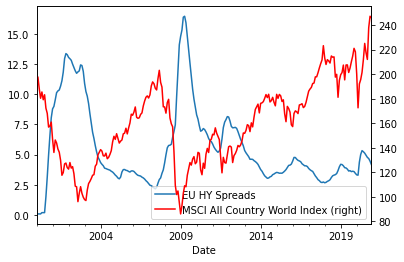

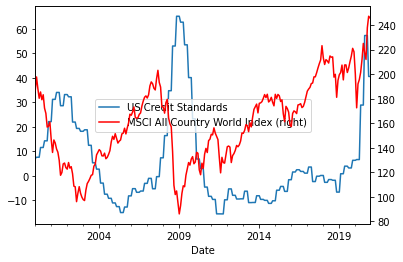

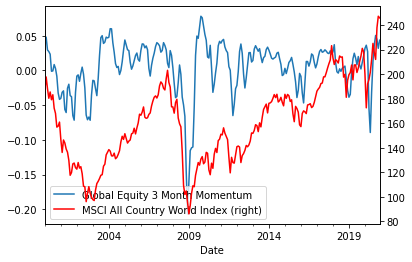

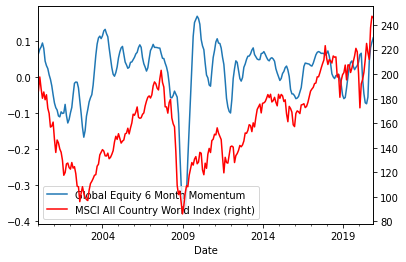

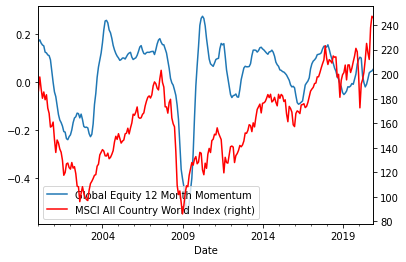

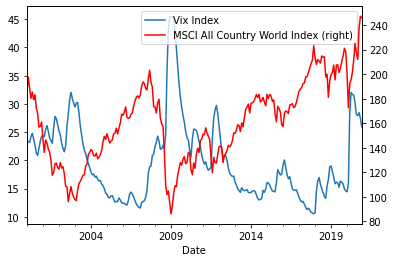

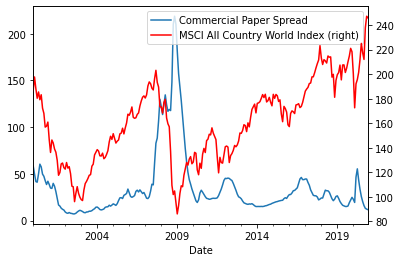

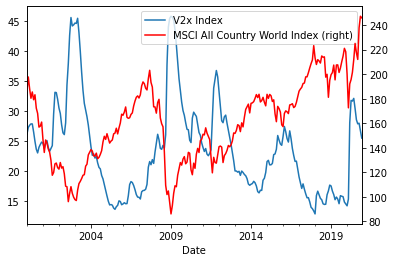

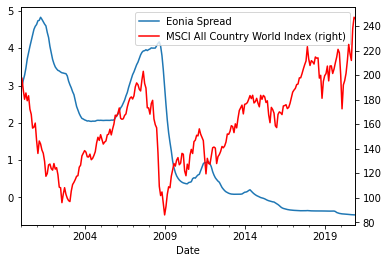

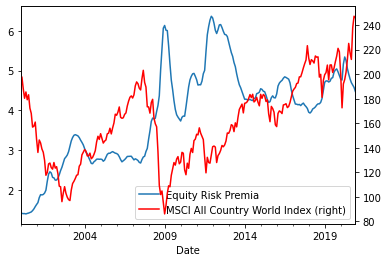

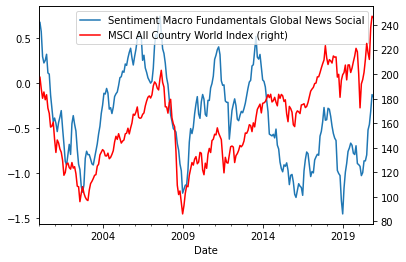

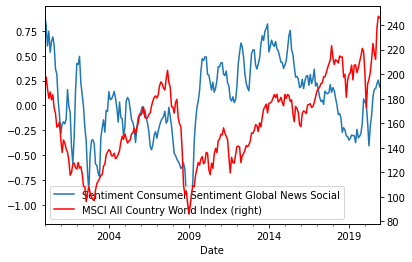

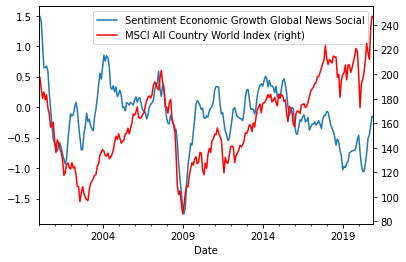

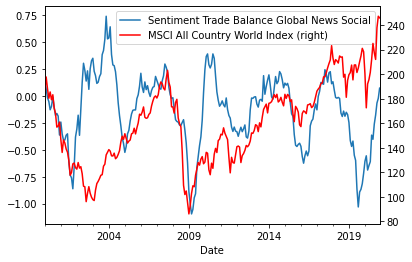

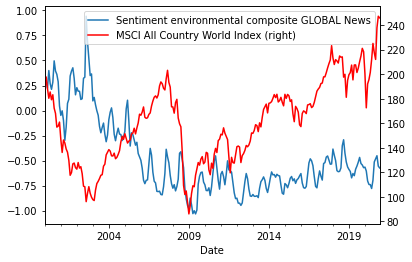

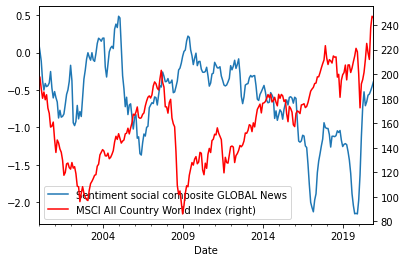

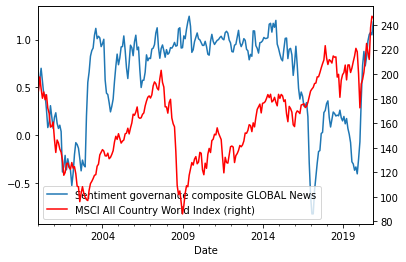

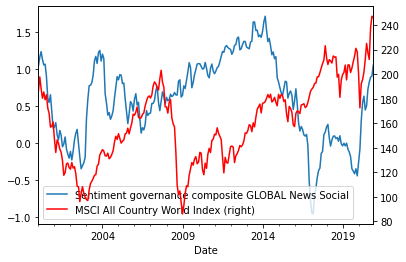

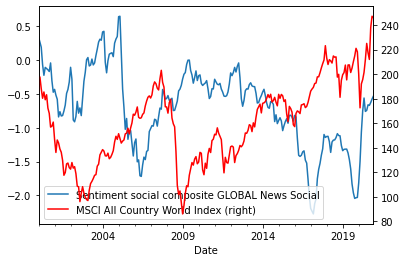

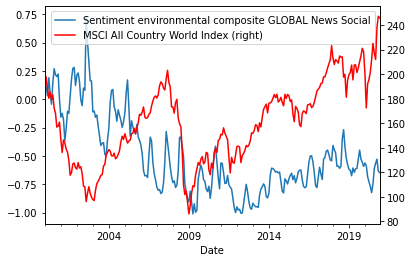

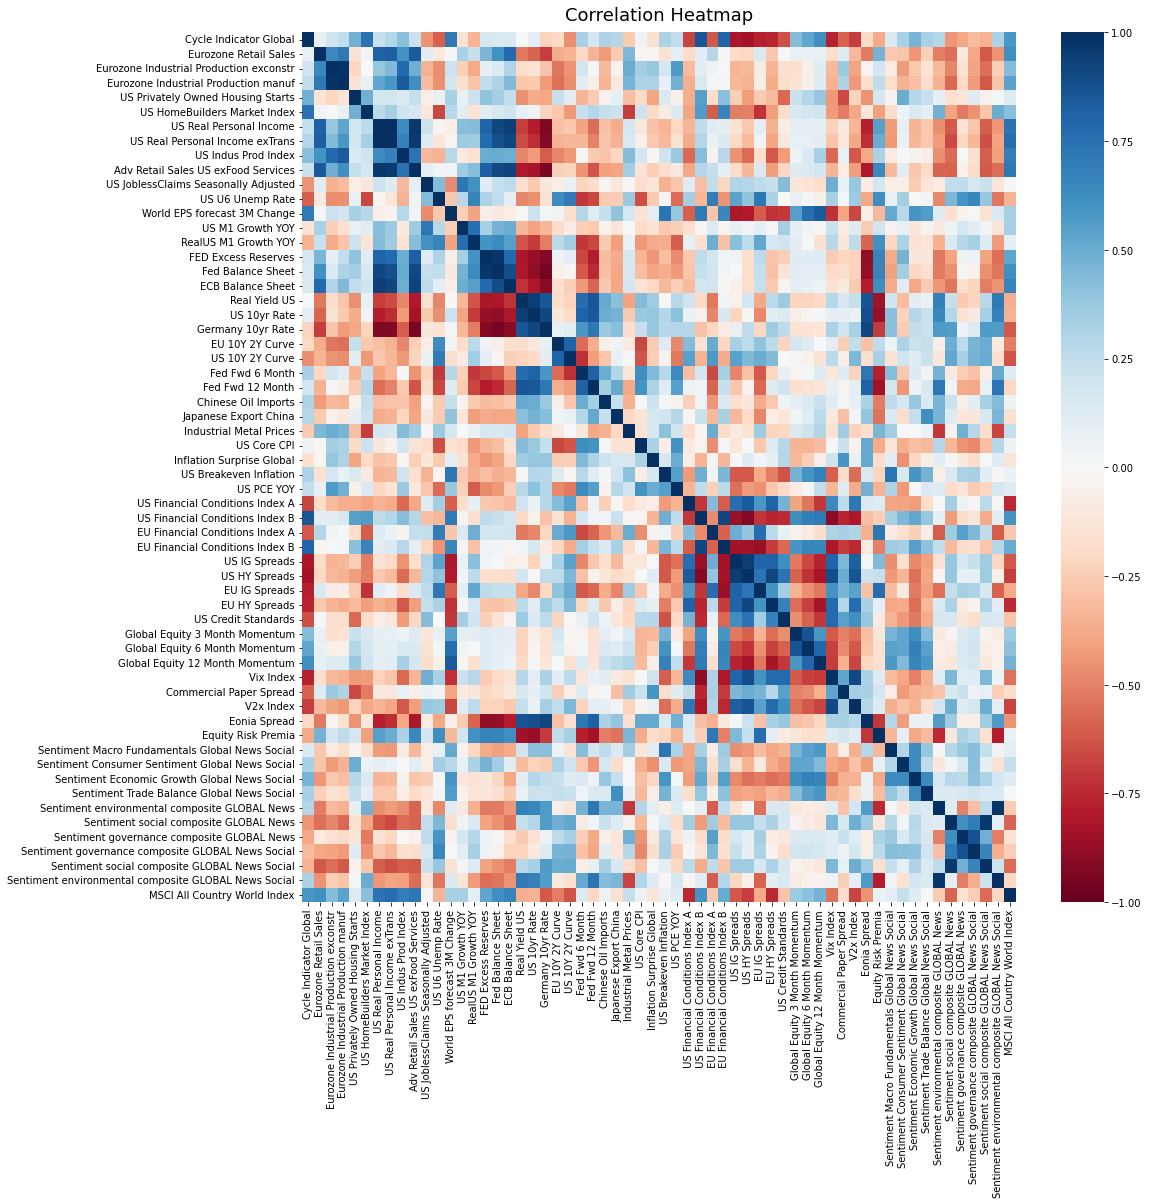

max corr: 0.9937938976346523 , min corr:  -0.9543419805723197


US Real Personal Income exTrans                US Real Personal Income                                 0.993794
Eurozone Industrial Production manuf           Eurozone Industrial Production exconstr                 0.984108
Sentiment environmental composite GLOBAL News  Sentiment environmental composite GLOBAL News Social    0.972994
Fed Balance Sheet                              FED Excess Reserves                                     0.971247
Sentiment social composite GLOBAL News         Sentiment social composite GLOBAL News Social           0.966078
US Real Personal Income                        Adv Retail Sales US exFood Services                     0.964242
dtype: float64

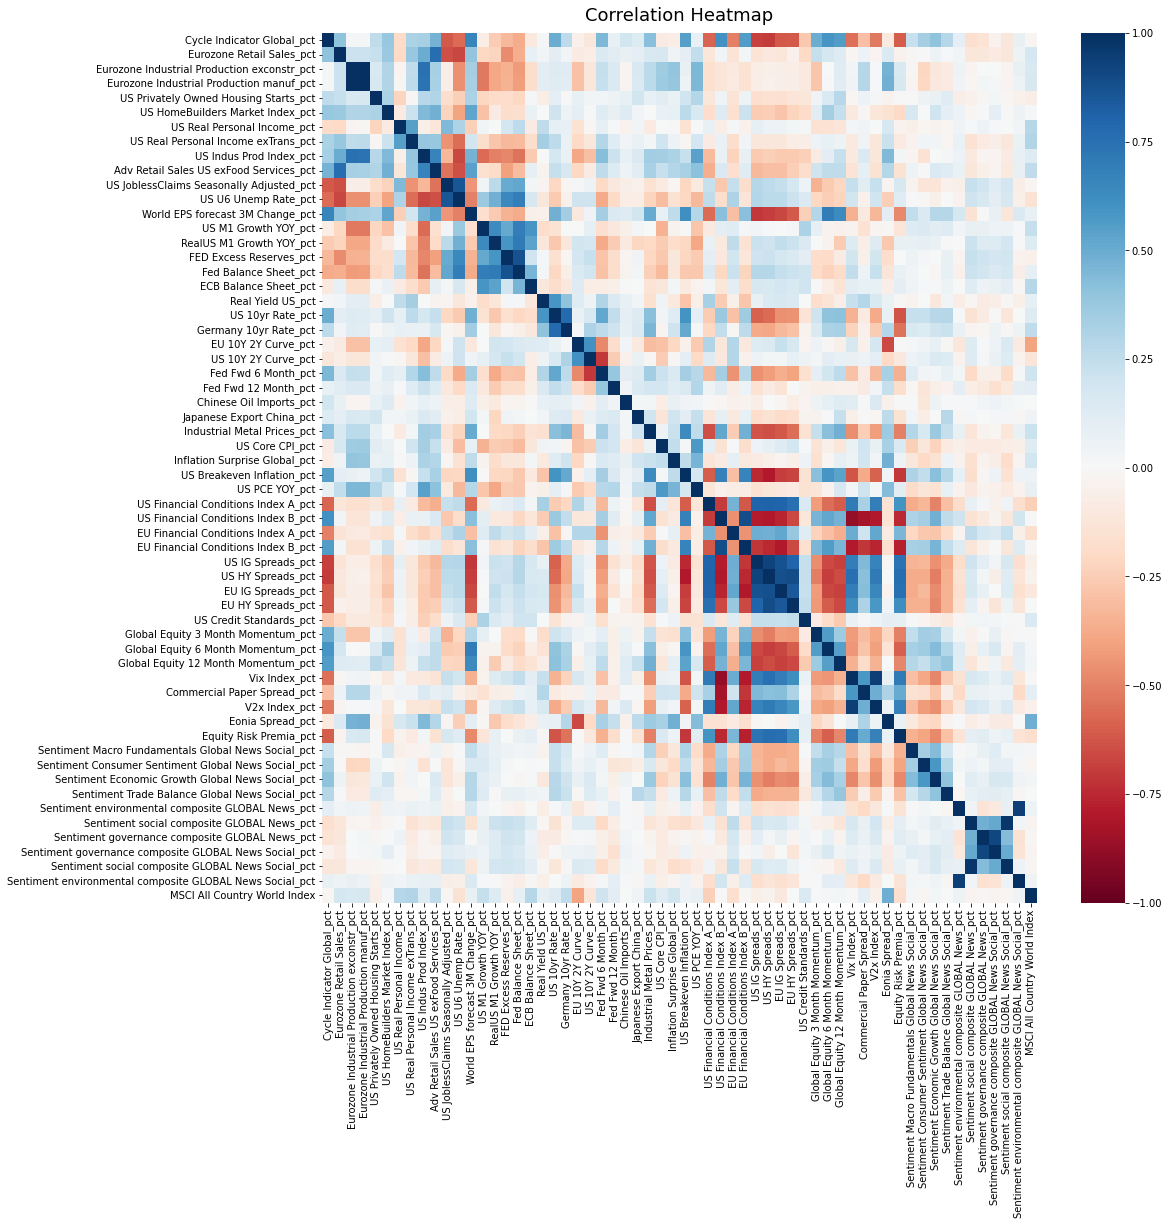

max corr: nan , min corr:  nan


Eurozone Industrial Production exconstr_pct        Eurozone Industrial Production manuf_pct      0.994290
Sentiment social composite GLOBAL News Social_pct  Sentiment social composite GLOBAL News_pct    0.974823
dtype: float64

Highly Correlated Features
 US Real Personal Income exTrans                US Real Personal Income                                 0.993794
Eurozone Industrial Production manuf           Eurozone Industrial Production exconstr                 0.984108
Sentiment environmental composite GLOBAL News  Sentiment environmental composite GLOBAL News Social    0.972994
Fed Balance Sheet                              FED Excess Reserves                                     0.971247
Sentiment social composite GLOBAL News         Sentiment social composite GLOBAL News Social           0.966078
US Real Personal Income                        Adv Retail Sales US exFood Services                     0.964242
dtype: float64
                                                    MSCI All Country World Index
MSCI All Country World Index                                            1.000000
US Real Personal Income exTrans                                         0.759325
 US Financial Conditions Index A          

C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWa

C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWa

C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWa

C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWa

C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWa

C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWa

C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
C:\Users\darya\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWa

Mean average percentage error of the model
 4.114765773918804 %


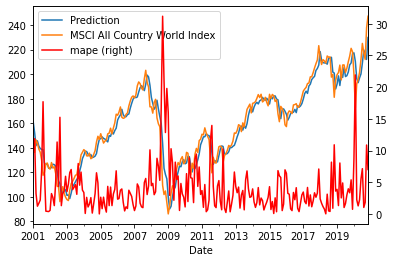

            Prediction  MSCI All Country World Index       mape
Date                                                           
2001-01-31  161.210621                    146.804135   9.813406
2001-02-28  152.376950                    136.200140  11.877235
2001-03-31  141.658930                    146.359610   3.211733
2001-04-30  145.692398                    143.927686   1.226110
2001-05-31  141.355108                    139.017804   1.681298
...                ...                           ...        ...
2020-07-31  209.001611                    225.083018   7.144656
2020-08-31  219.718467                    217.477425   1.030471
2020-09-30  215.889731                    212.013362   1.828361
2020-10-31  212.017769                    237.877832  10.871153
2020-11-30  229.887188                    247.224865   7.012918

[239 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>


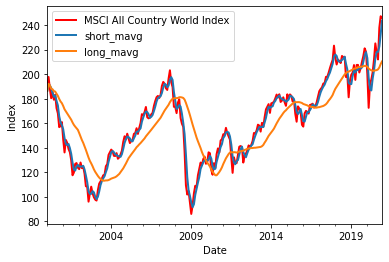

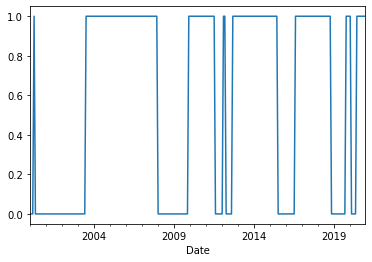

            Prediction  MSCI All Country World Index
Date                                                
2000-01-31         NaN                    186.455175
2000-02-29         NaN                    197.739786
2000-03-31         NaN                    188.164789
2000-04-30         NaN                    180.375545
2000-05-31         NaN                    185.504399
...                ...                           ...
2020-08-31  219.718467                    217.477425
2020-09-30  215.889731                    212.013362
2020-10-31  212.017769                    237.877832
2020-11-30  229.887188                    247.224865
2020-12-31         NaN                    245.910644

[252 rows x 2 columns]
            Prediction  MSCI All Country World Index  roll_short    roll_long  \
Date                                                                            
2000-01-31         NaN                    186.455175         NaN          NaN   
2000-02-29         NaN                    19

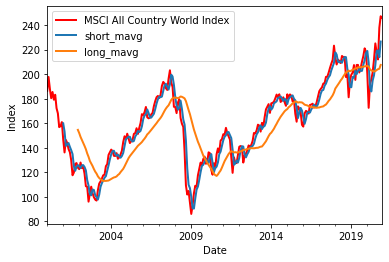

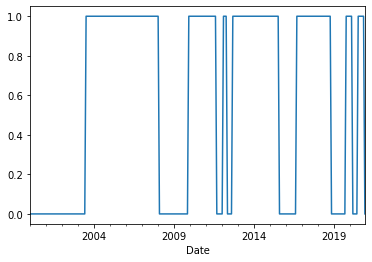

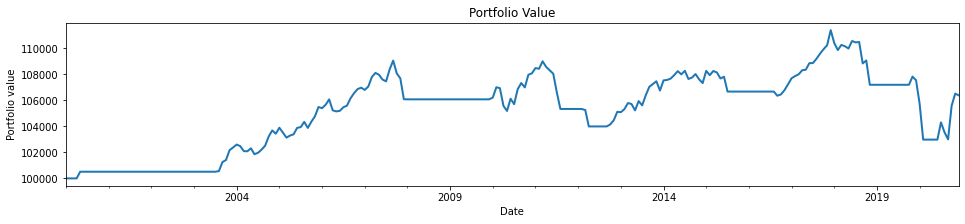

                   Index      holdings           cash          total   returns
Date                                                                          
2000-01-31      0.000000      0.000000  100000.000000  100000.000000       NaN
2000-02-29      0.000000      0.000000  100000.000000  100000.000000  0.000000
2000-03-31      0.000000      0.000000  100000.000000  100000.000000  0.000000
2000-04-30  18037.554454  18037.554454   81962.445546  100000.000000  0.000000
2000-05-31      0.000000      0.000000  100512.885473  100512.885473  0.005129
...                  ...           ...            ...            ...       ...
2020-07-31  22508.301793  22508.301793   81801.523193  104309.824986  0.012858
2020-08-31  21747.742540  21747.742540   81801.523193  103549.265732 -0.007291
2020-09-30  21201.336187  21201.336187   81801.523193  103002.859379 -0.005277
2020-10-31  23787.783232  23787.783232   81801.523193  105589.306424  0.025110
2020-11-30  24722.486481  24722.486481   81801.52319

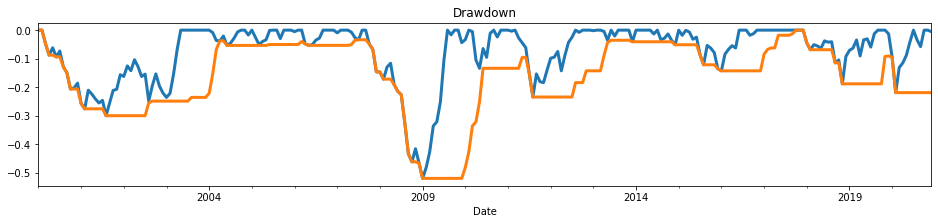

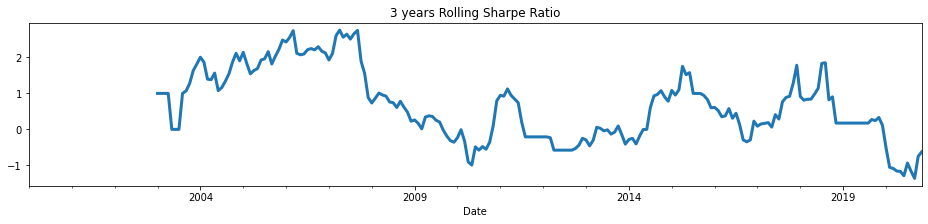

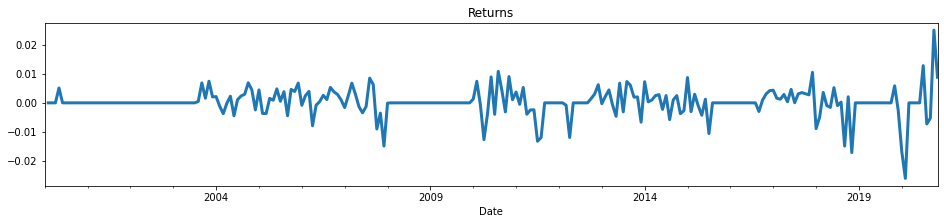

                         Values
Annualized sharpe_ratio    0.19
Maximum Drawdown, %      -52.04
Largest Monthly Gain, %    2.51
Largest Monthly Loss, %   -2.61
Total Return, %            6.52


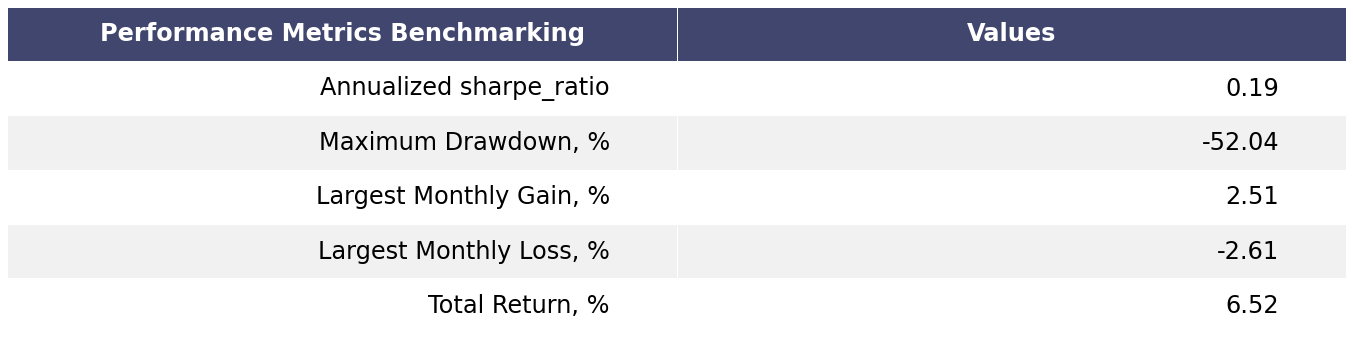

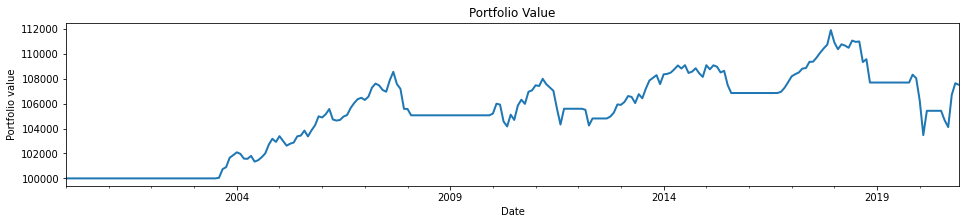

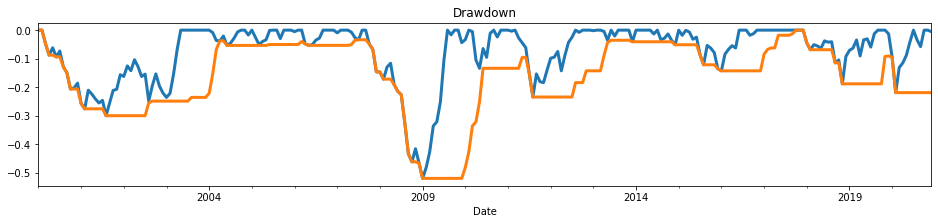

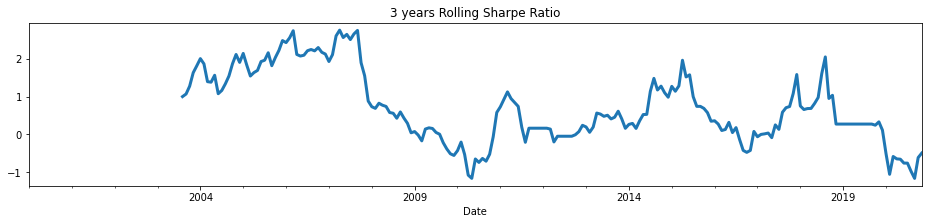

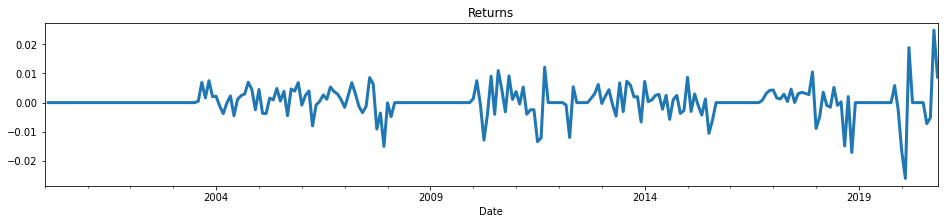

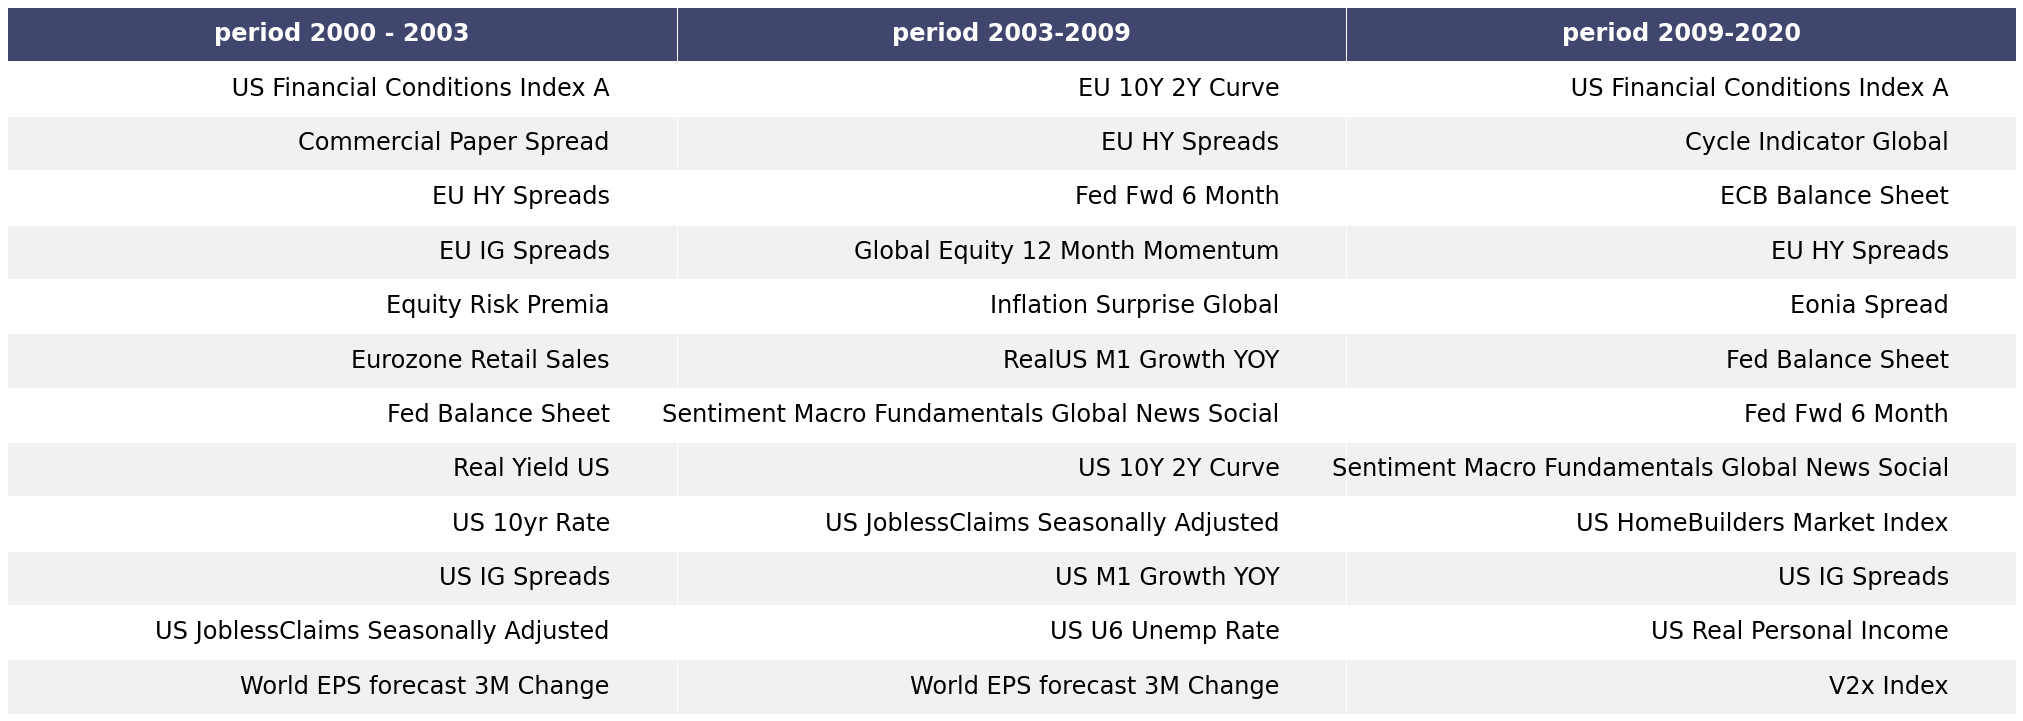

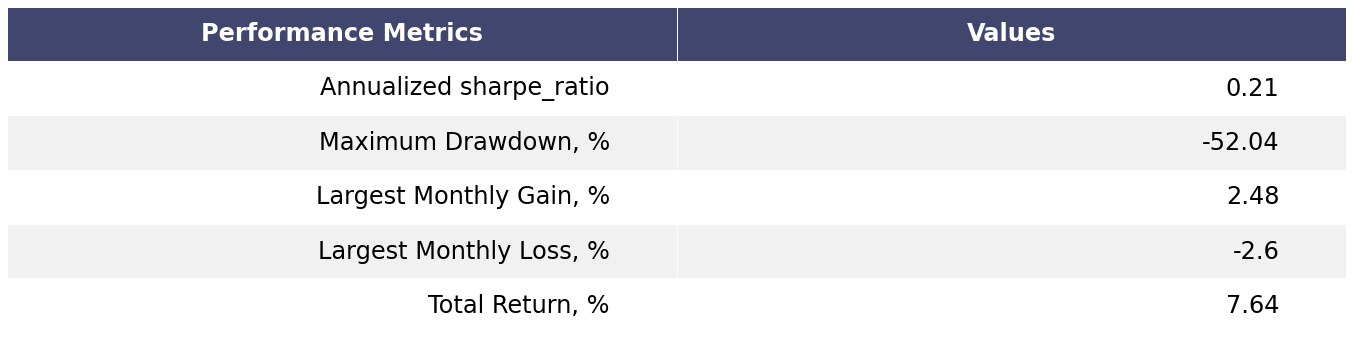

In [33]:
S_Main()

### End of Assignment